In [1]:
import os

try:
    snakemake
except NameError:
    from snakemk_util import load_rule_args
    
    os.chdir('../..')
    
    snakemake = load_rule_args(
        snakefile = os.getcwd() + "/workflow/Snakefile",
        rule_name = 'gnomad_loeuf_genes',
        root = '..'
    )

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator

In [3]:
from lapa.result import LapaResult

lapa = LapaResult(snakemake.input['lapa_dir'])
df_cluster = lapa.read_clusters().drop_duplicates(['Chromosome', 'Start', 'End', 'Strand'])

In [4]:
df_cluster['signal_seq'] = df_cluster['signal'].str.split('@').str.get(1)
df_cluster['signal_type'] = 'Non-canonical'
df_cluster.loc[df_cluster['signal_seq'] == 'AATAAA', 'signal_type'] = 'Canonical'
df_cluster.loc[df_cluster['signal_seq'] == 'None', 'signal_type'] = 'No Signal'

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Canonical vs. Non-canonical: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=3.515e+08
Canonical vs. No Signal: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=7.109e+07


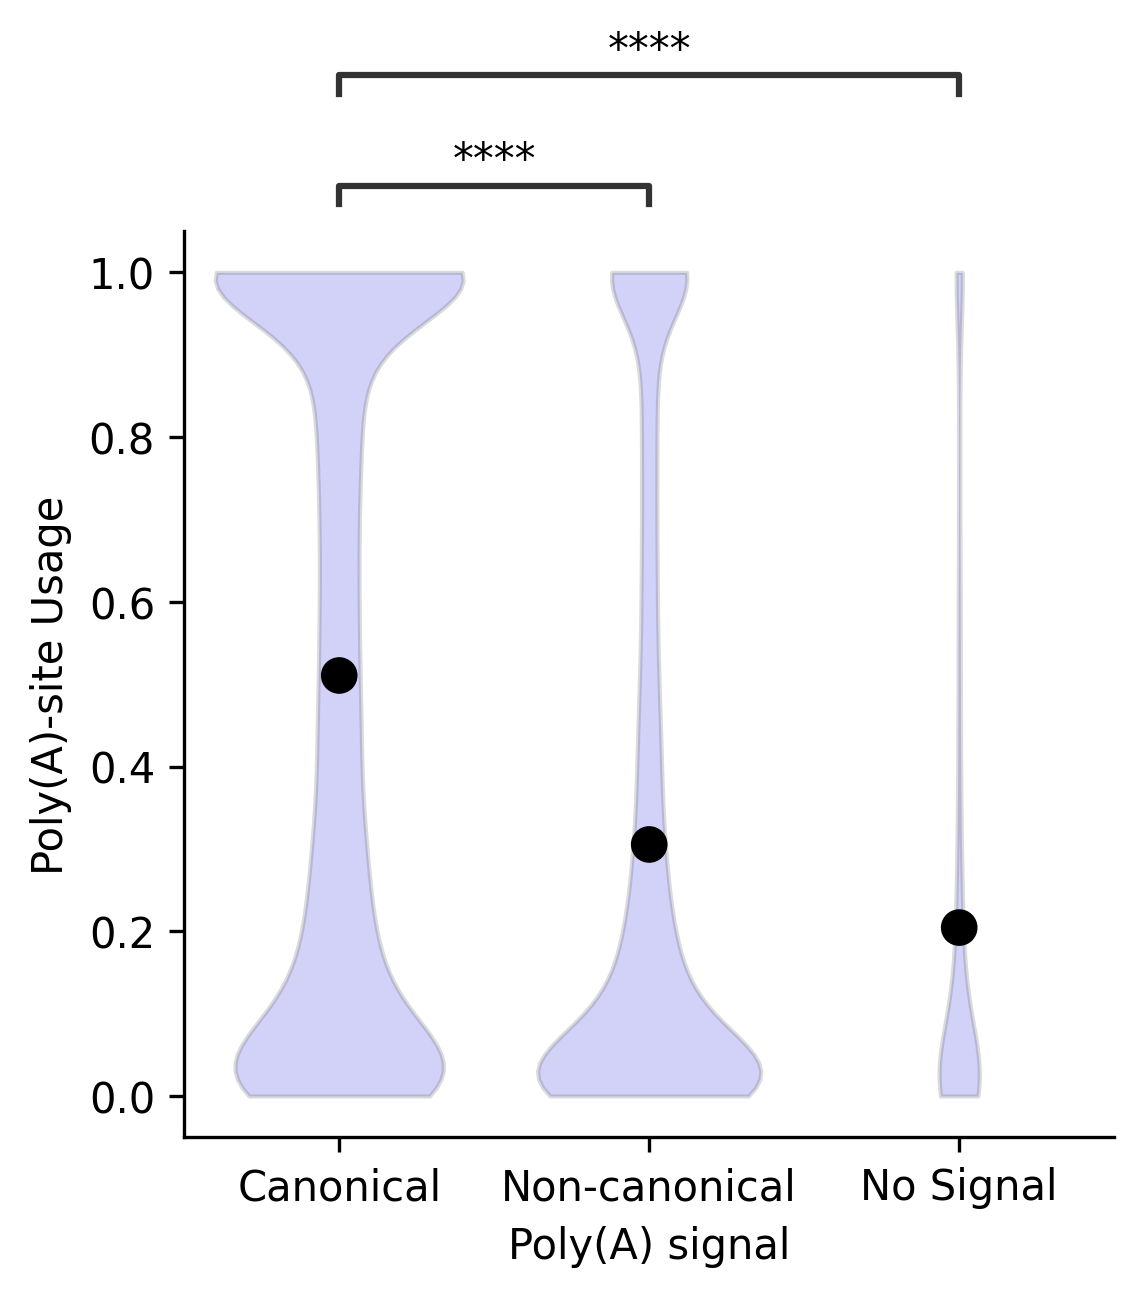

In [5]:
plt.figure(figsize=(4, 4), dpi=300)

ax = sns.violinplot(data=df_cluster, x='signal_type', y='usage', cut=0, color='blue', 
               scale="count", linewidth=1, inner=None)

for violin in ax.collections:
    violin.set_alpha(0.2)

ax = sns.pointplot(x="signal_type", y="usage", data=df_cluster, join=False, color='black')

annotator = Annotator(ax, [("Canonical", "Non-canonical"), ('Canonical', 'No Signal')], 
                      data=df_cluster, x='signal_type', y='usage')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()
sns.despine()

plt.xlabel('Poly(A) signal')
plt.ylabel('Poly(A)-site Usage')

plt.savefig(snakemake.output['fig_signal'], dpi=300, bbox_inches='tight', transparent=True)

In [6]:
df_loeuf_genes = pd.read_csv(snakemake.input['loeuf_decile']).set_index('gene_id')
df_loeuf_genes['oe_lof_upper_bin'] = (df_loeuf_genes['oe_lof_upper_bin'] * 10).round() \
    .astype(int).astype(str) + '%'

In [7]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar


with ProgressBar():
    df_polya = dd.read_csv(snakemake.input['variant_polya']).compute()
    
df_polya = df_polya[~df_polya['Start'].isna()]
df_polya = df_polya[df_polya['signal'] == 'AATAAA']

[########################################] | 100% Completed |  0.2s


In [8]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar


with ProgressBar():
    df_utr = dd.read_csv(snakemake.input['variant_3utr']).compute()
    
df_utr = df_utr[~df_utr['Start'].isna()]
df_utr = df_utr[df_utr['count'] > 0]

[########################################] | 100% Completed |  0.2s


In [9]:
df_utr['length'] = df_utr['End'] - df_utr['Start']
df_utr = df_utr.groupby('gene_id').sum()

In [10]:
df_polya['length'] = df_polya['End'] - df_polya['Start']
df_polya = df_polya.groupby('gene_id').sum()

In [11]:
df = df_polya[['count']].join(df_utr[['count']], rsuffix='_utr').join(df_loeuf_genes)
df = df[~df.isna().any(axis=1)]
df['ratio'] = df['count'] / df['count_utr']
df

,count,count_utr,oe_lof_upper_bin,ratio
gene_id,,,,
ENSG00000000457.13,32,678.0,20%,0.047198
ENSG00000001084.12,0,286.0,10%,0.000000
ENSG00000001461.16,0,838.0,40%,0.000000
ENSG00000001497.16,0,20.0,0%,0.000000
ENSG00000001561.6,0,505.0,30%,0.000000
...,...,...,...,...
ENSG00000269404.6,0,674.0,10%,0.000000
ENSG00000269858.5,0,111.0,20%,0.000000
ENSG00000270800.3,0,100.0,10%,0.000000


/pub/mcelik/anaconda/envs/rnawg/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


0% vs. 90%: Mann-Whitney-Wilcoxon test two-sided, P_val:4.234e-12 U_stat=1.545e+05


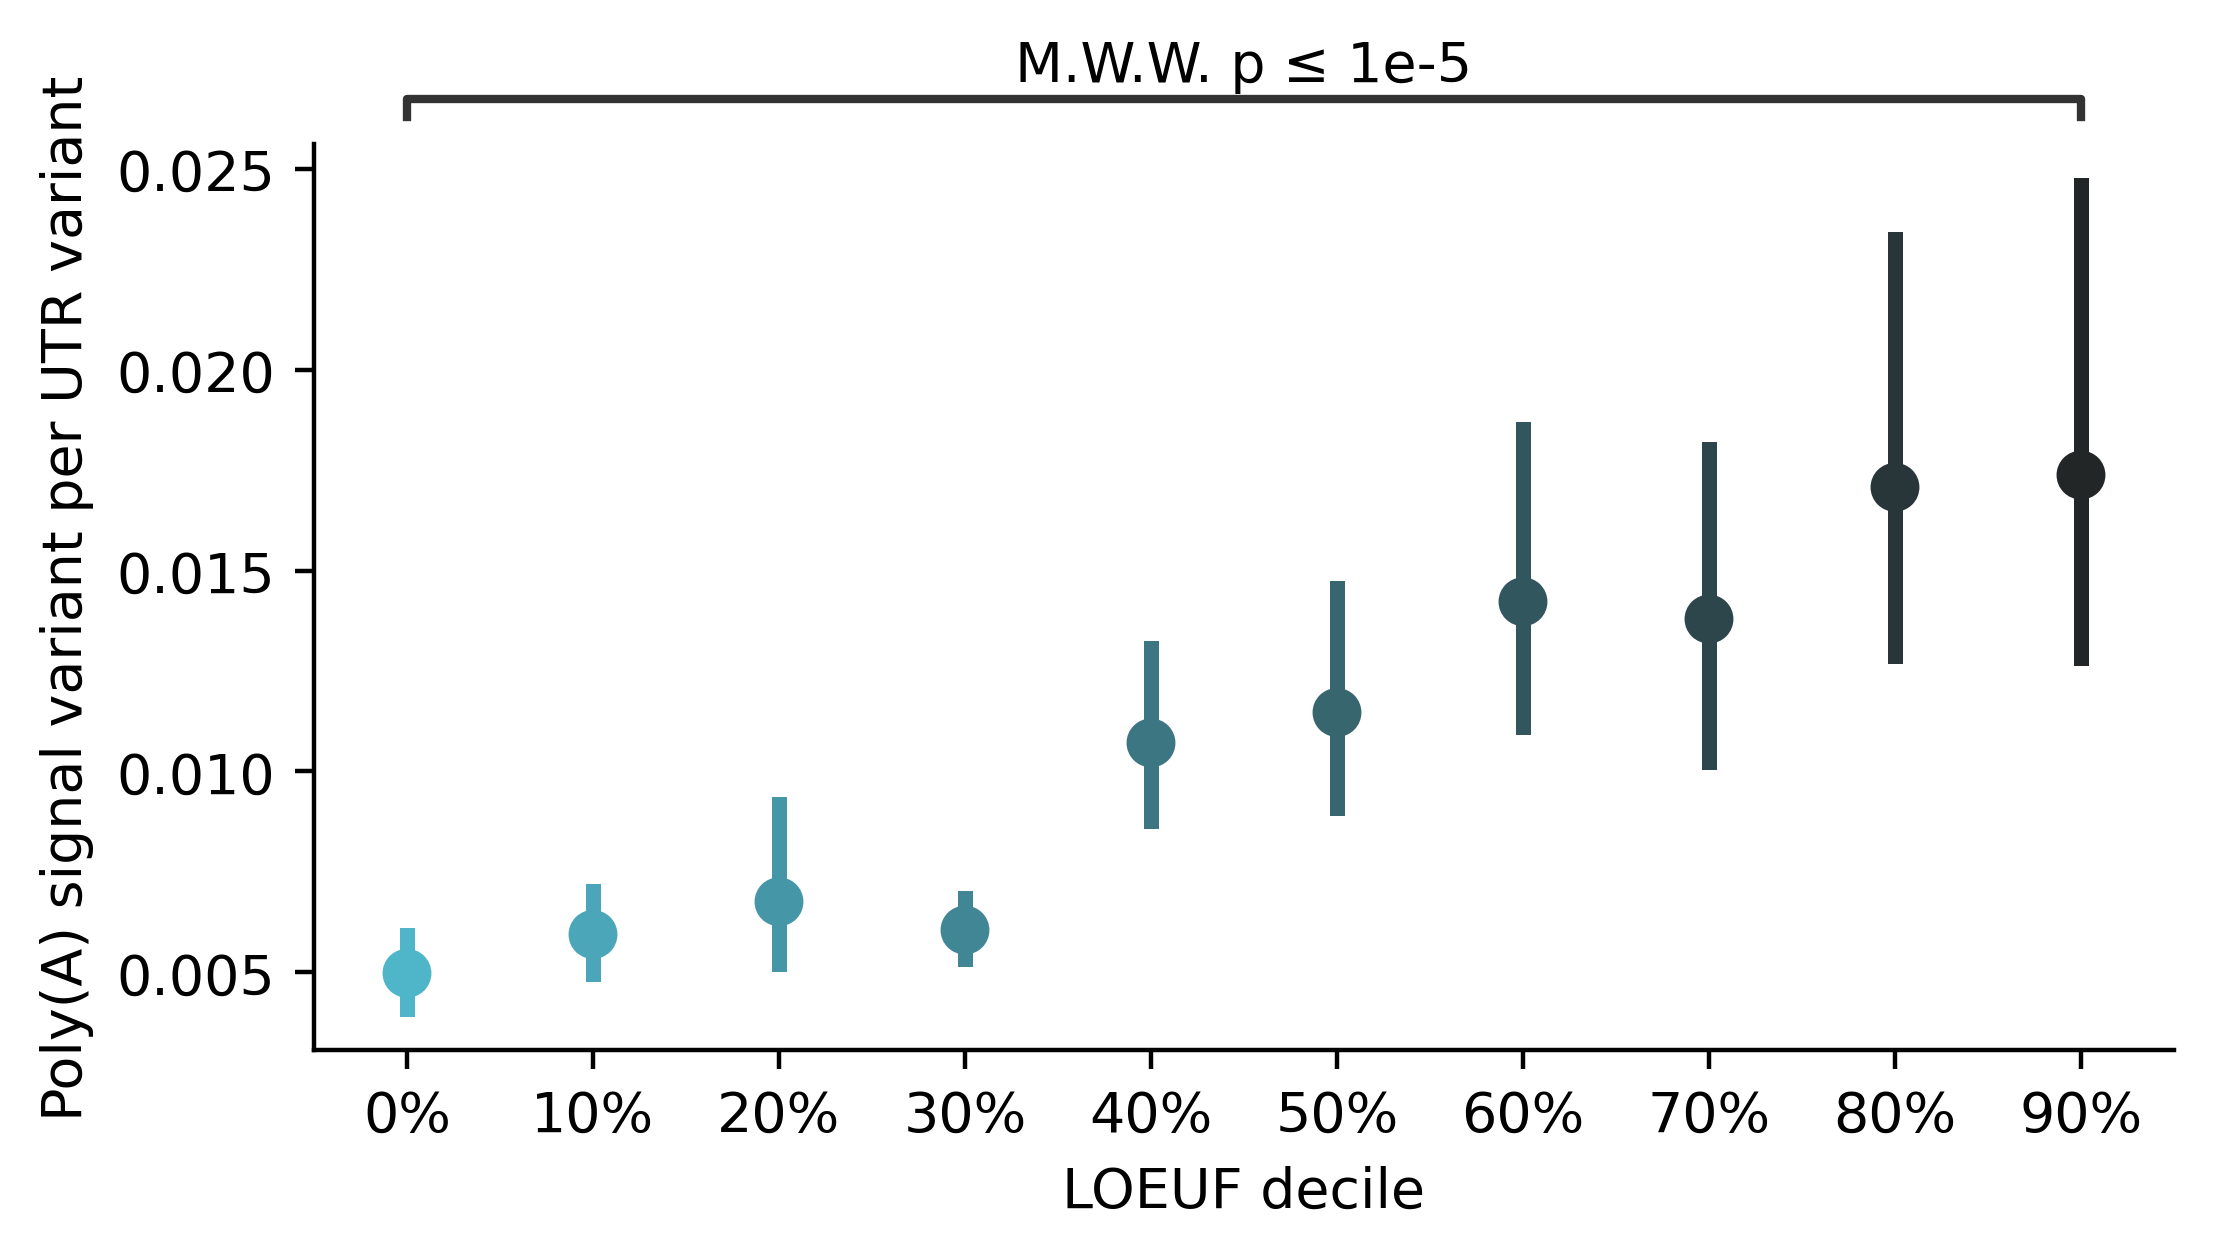

In [12]:
plt.figure(figsize=(6, 3), dpi=400)

order = ['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%']

ax = sns.pointplot(x="oe_lof_upper_bin", y="ratio", order=order, 
                   palette=sns.dark_palette("#4fb6ca", 10, reverse=True),
                   data=df.sort_values('oe_lof_upper_bin'), join=False)
sns.despine()
plt.ylabel('Poly(A) signal variant per UTR variant')
plt.xlabel('LOEUF decile')

annotator = Annotator(ax, [("0%", "90%")], data=df, x='oe_lof_upper_bin', y='ratio', order=order)
annotator.configure(test='Mann-Whitney', text_format='simple', loc='outside')
annotator.apply_and_annotate()

plt.savefig(snakemake.output['fig_loeuf'], dpi=300, bbox_inches='tight', transparent=True)